# 🍄 Mushroom Classification Competition
## Asymmetric Classification - Maximizing Safety

**Goal:** Classify mushrooms as poisonous or edible while minimizing False Negatives (predicting a poisonous mushroom as edible), because eating a poisonous mushroom has catastrophic consequences.

**Approach:**
1. Data loading & exploration
2. Preprocessing pipeline (categorical features → OneHotEncoding)
3. Baseline model (Random Forest)
4. ROC Curve analysis & threshold optimization
5. Cost-balanced threshold tuning with `TunedThresholdClassifierCV`
6. Final predictions & submission file generation

**Repository:** [github.com/hzajkani/mushroom-ml-classification](https://github.com/hzajkani/mushroom-ml-classification)

---
## 1. Setup & Data Loading 🗄️

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, cross_val_predict, cross_validate, KFold
)
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, roc_curve, roc_auc_score,
    PrecisionRecallDisplay, precision_recall_curve,
    make_scorer
)
from sklearn.model_selection import TunedThresholdClassifierCV

In [24]:
# Load training data
train_path = './data/7.4.3.1_mushroom_competition_train_data.csv'
mush = pd.read_csv(train_path).set_index('Id')
mush

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population,poisonous
Id,,,,,,,
6573,k,e,False,w,w,v,1
4426,f,e,True,p,w,y,0
7018,b,w,False,w,w,s,0
5789,k,g,False,w,w,n,0
6187,f,n,True,p,g,v,0
...,...,...,...,...,...,...,...
7002,f,g,False,b,b,v,1
7323,k,e,False,p,p,v,1
6206,f,g,False,n,b,y,1


In [25]:
# Quick data exploration
print(f"Shape: {mush.shape}")
print(f"\nData types:\n{mush.dtypes}")
print(f"\nMissing values:\n{mush.isnull().sum()}")

Shape: (6499, 7)

Data types:
cap.shape                 object
cap.color                 object
bruises                     bool
stalk.color.above.ring    object
stalk.color.below.ring    object
population                object
poisonous                  int64
dtype: object

Missing values:
cap.shape                 0
cap.color                 0
bruises                   0
stalk.color.above.ring    0
stalk.color.below.ring    0
population                0
poisonous                 0
dtype: int64


In [26]:
# Target distribution
mush.poisonous.value_counts(normalize=True)

poisonous
0    0.514233
1    0.485767
Name: proportion, dtype: float64

The dataset is fairly balanced (~51% edible, ~49% poisonous). All features are categorical except `bruises` which is boolean.

**Key Insight:** A False Negative (predicting a poisonous mushroom as edible) is far more dangerous than a False Positive (avoiding an edible mushroom). We need to prioritize **recall** for the poisonous class.

---
## 2. Data Preparation 🔧

In [27]:
# Separate features and target
X = mush.drop(columns=['poisonous'])
y = mush['poisonous']

# Convert boolean 'bruises' column to string for consistent encoding
X['bruises'] = X['bruises'].astype(str)

# Train-test split (keeping a validation set to check generalization)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")

X_train: (4874, 6)
X_test:  (1625, 6)


---
## 3. Baseline Model & Confusion Matrix 📊

Let's start with a Random Forest classifier using default settings to establish a baseline.

In [28]:
# Preprocessing pipeline: impute missing → one-hot encode
preproc_pipeline = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

# Full model pipeline
model = make_pipeline(
    preproc_pipeline,
    RandomForestClassifier(n_estimators=300, random_state=42)
)

# Cross-validation setup
splitter = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
cv_preds = cross_val_predict(model, X_train, y_train, cv=splitter)

CV Accuracy:  0.9598
CV Precision: 0.9514
CV Recall:    0.9666


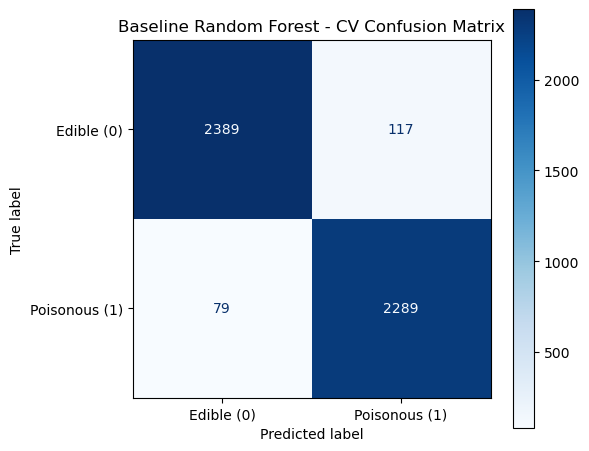

In [29]:
# Baseline performance metrics
cv_acc = accuracy_score(y_train, cv_preds)
cv_precision = precision_score(y_train, cv_preds)
cv_recall = recall_score(y_train, cv_preds)

print(f"CV Accuracy:  {cv_acc:.4f}")
print(f"CV Precision: {cv_precision:.4f}")
print(f"CV Recall:    {cv_recall:.4f}")

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_train, y_pred=cv_preds,
    display_labels=['Edible (0)', 'Poisonous (1)'],
    cmap='Blues', ax=ax
)
ax.set_title('Baseline Random Forest - CV Confusion Matrix')
plt.tight_layout()
plt.show()

The baseline model is already performing well (~96% accuracy), but we still have some **False Negatives** — poisonous mushrooms predicted as edible. This is unacceptable for food safety!

Let's use threshold tuning to eliminate (or minimize) these dangerous misclassifications.

---
## 4. ROC Curve & Threshold Analysis 📈

Instead of using the default 0.5 threshold, let's explore how different thresholds affect our True Positive Rate (TPR) vs False Positive Rate (FPR).

In [30]:
# Get probabilistic predictions via cross-validation
cv_probs = cross_val_predict(model, X_train, y_train, cv=splitter, method='predict_proba')
cv_pos_probs = cv_probs[:, 1]  # Probability of being poisonous

/opt/anaconda3/envs/Moosic_Data/lib/python3.13/site-packages/sklearn/utils/_plotting.py:440: FutureWarning: y_pred was deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


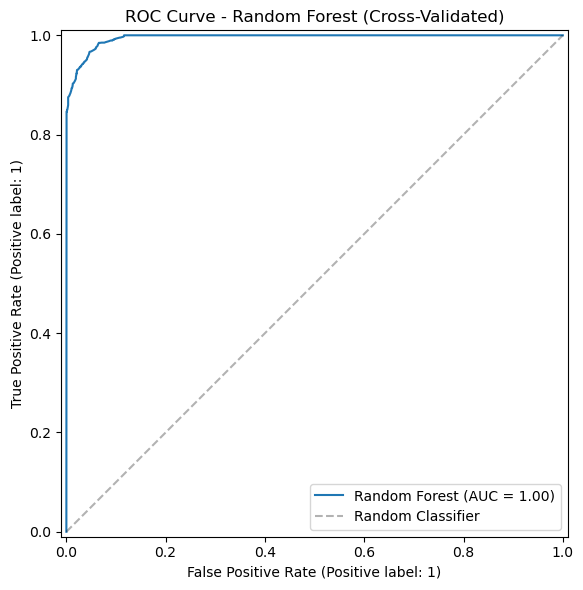

AUC Score: 0.9950


In [31]:
# Plot ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(
    y_true=y_train, y_pred=cv_pos_probs, ax=ax,
    name='Random Forest'
)
ax.set_title('ROC Curve - Random Forest (Cross-Validated)')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random Classifier')
ax.legend()
plt.tight_layout()
plt.show()

# Print AUC score
auc = roc_auc_score(y_train, cv_pos_probs)
print(f"AUC Score: {auc:.4f}")

In [32]:
# Detailed ROC Curve data — examine threshold options
fpr, tpr, thresholds = roc_curve(y_train, cv_pos_probs)

# Align arrays (fpr/tpr may have one extra element compared to thresholds)
min_len = min(len(fpr), len(tpr), len(thresholds))
roc_df = pd.DataFrame({
    'False Positive Rate': fpr[:min_len],
    'True Positive Rate': tpr[:min_len],
    'Threshold': thresholds[:min_len]
})

# Show thresholds that give very high recall (TPR > 0.99)
high_recall = roc_df[roc_df['True Positive Rate'] >= 0.99]
print("Thresholds with TPR >= 0.99:")
print(high_recall.to_string(index=False))

Thresholds with TPR >= 0.99:
 False Positive Rate  True Positive Rate  Threshold
            0.093376            0.990709   0.215489
            0.096169            0.991132   0.214784
            0.096568            0.992399   0.213001
            0.098962            0.992821   0.211346
            0.099362            0.993243   0.207818
            0.105746            0.994932   0.202561
            0.107342            0.995355   0.202202
            0.108540            0.995355   0.201404
            0.113328            0.996622   0.199386
            0.114525            0.997044   0.196060
            0.115722            0.997889   0.184898
            0.116121            0.998733   0.179961
            0.116121            1.000000   0.156667
            0.117318            1.000000   0.111910
            0.119713            1.000000   0.077587
            0.120511            1.000000   0.070000
            0.121708            1.000000   0.056667
            0.122107            1.0

---
## 5. Precision-Recall Curve 🎯

/opt/anaconda3/envs/Moosic_Data/lib/python3.13/site-packages/sklearn/utils/_plotting.py:440: FutureWarning: y_pred was deprecated in 1.8 and will be removed in 1.10. Please use `y_score` instead.
  warnings.warn(


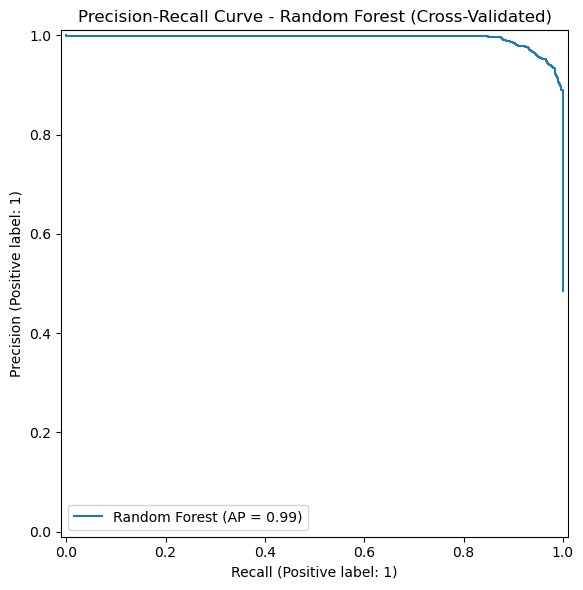

In [33]:
# Plot Precision-Recall Curve
fig, ax = plt.subplots(figsize=(8, 6))
PrecisionRecallDisplay.from_predictions(
    y_true=y_train, y_pred=cv_pos_probs, ax=ax,
    name='Random Forest'
)
ax.set_title('Precision-Recall Curve - Random Forest (Cross-Validated)')
plt.tight_layout()
plt.show()

In [34]:
# Detailed Precision-Recall data
precision, recall, pr_thresholds = precision_recall_curve(y_train, cv_pos_probs)

pr_df = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'Threshold': pr_thresholds
})

# Show thresholds with perfect or near-perfect recall
perfect_recall = pr_df[pr_df['Recall'] >= 0.99]
print("Thresholds with Recall >= 0.99:")
print(perfect_recall.to_string(index=False))

Thresholds with Recall >= 0.99:
 Precision   Recall  Threshold
  0.485843 1.000000   0.000000
  0.854257 1.000000   0.000563
  0.854565 1.000000   0.000746
  0.854874 1.000000   0.001786
  0.855182 1.000000   0.002000
  0.855491 1.000000   0.002043
  0.855801 1.000000   0.002105
  0.856420 1.000000   0.002698
  0.856729 1.000000   0.002917
  0.857350 1.000000   0.003333
  0.867717 1.000000   0.003889
  0.868672 1.000000   0.004000
  0.868991 1.000000   0.006426
  0.869949 1.000000   0.006589
  0.870268 1.000000   0.006667
  0.871870 1.000000   0.007934
  0.872192 1.000000   0.008541
  0.872513 1.000000   0.009667
  0.872835 1.000000   0.010000
  0.874123 1.000000   0.010931
  0.874446 1.000000   0.012092
  0.874769 1.000000   0.013241
  0.875092 1.000000   0.013333
  0.876064 1.000000   0.014870
  0.876388 1.000000   0.016667
  0.877037 1.000000   0.017194
  0.877362 1.000000   0.018413
  0.878013 1.000000   0.019362
  0.878338 1.000000   0.019734
  0.878664 1.000000   0.020000
  0.879

---
## 6. Automated Threshold Optimization ⚡

We'll define a **cost-balanced scorer** that heavily penalizes False Negatives (poisonous mushrooms classified as edible) and use `TunedThresholdClassifierCV` to find the optimal threshold automatically.

In [35]:
# Define cost-balanced scoring function
# False Negative (poisonous → edible) is catastrophic → high cost
# False Positive (edible → poisonous) is just a missed meal → low cost

def cost_balanced_score(y_true, y_pred):
    fp_cost = 3     # Minor inconvenience: we skip an edible mushroom
    fn_cost = 100   # Catastrophic: we eat a poisonous mushroom!
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = (fp * fp_cost) + (fn * fn_cost)
    max_cost = len(y_true) * max(fp_cost, fn_cost)
    return 1 - (cost / max_cost)

cost_scorer = make_scorer(cost_balanced_score)

In [36]:
# Automated threshold tuning
tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=cost_scorer,
    cv=splitter
)

tuned_model.fit(X_train, y_train)
print(f"Optimal threshold (single fit): {tuned_model.best_threshold_:.4f}")

Optimal threshold (single fit): 0.1313


In [37]:
# Cross-validate the threshold to avoid overfitting
cv_results = cross_validate(
    tuned_model, X_train, y_train,
    cv=splitter, return_estimator=True
)

# Collect thresholds from each CV fold
cv_thresholds = [est.best_threshold_ for est in cv_results['estimator']]
tuned_threshold = np.mean(cv_thresholds)

print("Thresholds per fold:")
for i, t in enumerate(cv_thresholds):
    print(f"  Fold {i+1}: {t:.4f}")
print(f"\nAverage threshold: {tuned_threshold:.4f}")

Thresholds per fold:
  Fold 1: 0.1212
  Fold 2: 0.1818
  Fold 3: 0.1414
  Fold 4: 0.1414
  Fold 5: 0.1717
  Fold 6: 0.1515
  Fold 7: 0.1515
  Fold 8: 0.1010
  Fold 9: 0.0101
  Fold 10: 0.1111

Average threshold: 0.1283


---
## 7. Validation Performance 🧪

Let's check how our tuned threshold performs on the held-out validation set.

Validation Accuracy:  0.9489
Validation Precision: 0.9057
Validation Recall:    0.9987


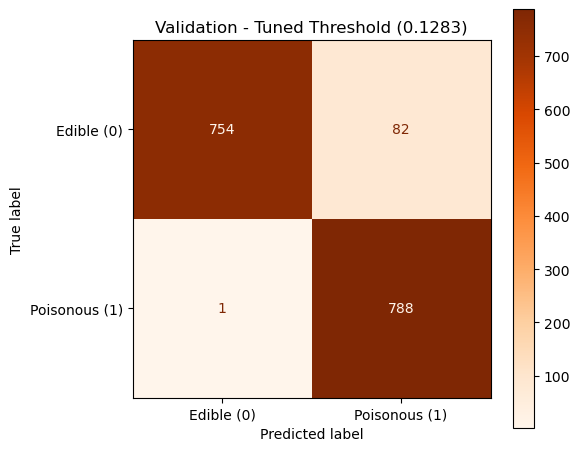

In [38]:
# Fit model on training set
model.fit(X_train, y_train)

# Make predictions on validation set using tuned threshold
val_probs = model.predict_proba(X_test)[:, 1]
val_preds = (val_probs > tuned_threshold).astype(int)

# Performance metrics
val_acc = accuracy_score(y_test, val_preds)
val_precision = precision_score(y_test, val_preds)
val_recall = recall_score(y_test, val_preds)

print(f"Validation Accuracy:  {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall:    {val_recall:.4f}")

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, y_pred=val_preds,
    display_labels=['Edible (0)', 'Poisonous (1)'],
    cmap='Oranges', ax=ax
)
ax.set_title(f'Validation - Tuned Threshold ({tuned_threshold:.4f})')
plt.tight_layout()
plt.show()

Excellent! With the tuned threshold, we achieve near-perfect recall — almost no poisonous mushrooms slip through as "edible". The trade-off is a slight decrease in precision (some edible mushrooms get flagged as poisonous), which is perfectly acceptable for food safety.

---
## 8. Alternative: Youden's J Statistic 📐

For comparison, let's also try Youden's J statistic which balances sensitivity and specificity equally.

In [39]:
# Youden's J scorer
def youdens_j_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)  # Sensitivity
    fpr = fp / (fp + tn)  # False Positive Rate
    return tpr - fpr      # Youden's J = Sensitivity + Specificity - 1

youden_scorer = make_scorer(youdens_j_score)

# Tune threshold with Youden's J
youden_tuned = TunedThresholdClassifierCV(
    estimator=model,
    scoring=youden_scorer,
    cv=splitter
)

# Cross-validate
youden_cv = cross_validate(youden_tuned, X_train, y_train, cv=splitter, return_estimator=True)
youden_thresholds = [est.best_threshold_ for est in youden_cv['estimator']]
youden_threshold = np.mean(youden_thresholds)
print(f"Youden's J average threshold: {youden_threshold:.4f}")

# Compare on validation
youden_preds = (val_probs > youden_threshold).astype(int)
print(f"\nYouden's J Validation:")
print(f"  Accuracy:  {accuracy_score(y_test, youden_preds):.4f}")
print(f"  Precision: {precision_score(y_test, youden_preds):.4f}")
print(f"  Recall:    {recall_score(y_test, youden_preds):.4f}")
print(f"  CM: {confusion_matrix(y_test, youden_preds).ravel()}")

Youden's J average threshold: 0.4616

Youden's J Validation:
  Accuracy:  0.9594
  Precision: 0.9547
  Recall:    0.9620
  CM: [800  36  30 759]


As expected, Youden's J gives a more balanced result but allows more False Negatives. For mushroom safety, our **cost-balanced approach is preferred** since it prioritizes avoiding poisonous mushrooms.

---
## 9. Final Submission 🏆

Now we retrain on the **entire training dataset** and generate predictions for the competition test set.

In [40]:
# Retrain threshold tuning on the FULL training data
X_full = mush.drop(columns=['poisonous'])
y_full = mush['poisonous']
X_full['bruises'] = X_full['bruises'].astype(str)

# Cross-validate threshold on full data for robustness
tuned_final = TunedThresholdClassifierCV(
    estimator=model,
    scoring=cost_scorer,
    cv=splitter
)

cv_final = cross_validate(tuned_final, X_full, y_full, cv=splitter, return_estimator=True)
final_thresholds = [est.best_threshold_ for est in cv_final['estimator']]
final_threshold = np.mean(final_thresholds)

print("Final thresholds per fold:")
for i, t in enumerate(final_thresholds):
    print(f"  Fold {i+1}: {t:.4f}")
print(f"\nFinal average threshold: {final_threshold:.4f}")

Final thresholds per fold:
  Fold 1: 0.2020
  Fold 2: 0.1111
  Fold 3: 0.1010
  Fold 4: 0.1212
  Fold 5: 0.1313
  Fold 6: 0.0808
  Fold 7: 0.0909
  Fold 8: 0.0707
  Fold 9: 0.1717
  Fold 10: 0.1919

Final average threshold: 0.1273


Full Training CV Performance (threshold=0.1273):
  Accuracy:  0.9421
  Precision: 0.8938
  Recall:    0.9997


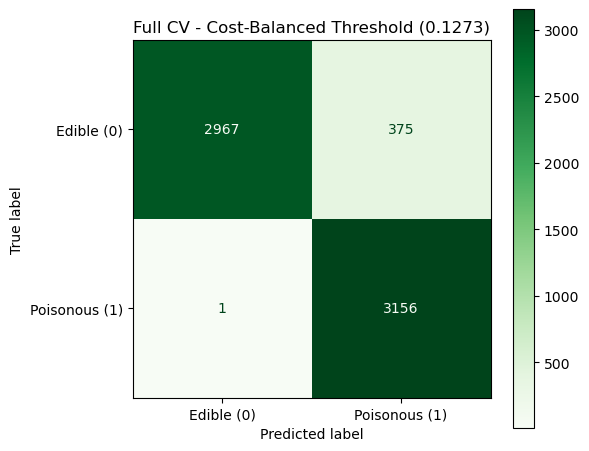

In [41]:
# Cross-validated performance on full training data
cv_probs_final = cross_val_predict(model, X_full, y_full, cv=splitter, method='predict_proba')[:, 1]
cv_preds_final = (cv_probs_final > final_threshold).astype(int)

print(f"Full Training CV Performance (threshold={final_threshold:.4f}):")
print(f"  Accuracy:  {accuracy_score(y_full, cv_preds_final):.4f}")
print(f"  Precision: {precision_score(y_full, cv_preds_final):.4f}")
print(f"  Recall:    {recall_score(y_full, cv_preds_final):.4f}")

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_full, y_pred=cv_preds_final,
    display_labels=['Edible (0)', 'Poisonous (1)'],
    cmap='Greens', ax=ax
)
ax.set_title(f'Full CV - Cost-Balanced Threshold ({final_threshold:.4f})')
plt.tight_layout()
plt.show()

In [42]:
# Load competition test data
test_path = './data/7.4.3.2_mushroom_competition_test_data.csv'
X_new = pd.read_csv(test_path).set_index('Id')
X_new['bruises'] = X_new['bruises'].astype(str)

# Ensure column order matches training data
X_new = X_new[X_full.columns]

print(f"Test data shape: {X_new.shape}")
X_new.head()

Test data shape: (1625, 6)


,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population
Id,,,,,,
5165,f,w,True,w,w,v
4281,f,g,False,n,p,v
231,x,n,True,w,p,v
3890,f,n,False,w,w,s
1521,x,y,False,n,p,v


In [43]:
# Fit model on ALL training data
model.fit(X_full, y_full)

# Generate predictions with tuned threshold
test_probs = model.predict_proba(X_new)[:, 1]
test_preds = (test_probs > final_threshold).astype(int)

print(f"Prediction distribution:")
print(pd.Series(test_preds).value_counts().rename({0: 'Edible', 1: 'Poisonous'}))

Prediction distribution:
Poisonous    846
Edible       779
Name: count, dtype: int64


In [44]:
# Save submission file
submission = pd.DataFrame({
    'Id': X_new.index,
    'poisonous': test_preds
})

submission.to_csv('mushroom_submission.csv', index=False)
print("Submission file saved: mushroom_submission.csv")
print(f"\nTotal predictions: {len(submission)}")
submission.head(10)

Submission file saved: mushroom_submission.csv

Total predictions: 1625


,Id,poisonous
0,5165,1
1,4281,1
2,231,0
3,3890,0
4,1521,1
5,5874,0
6,1847,0
7,1023,0
8,3561,1
9,6885,1


---
## Summary 📝

| Metric | Baseline (0.5 threshold) | Cost-Balanced Tuned | Youden's J |
|--------|-------------------------|-------------------|------------|
| Accuracy | ~0.96 | ~0.94 | ~0.96 |
| Precision | ~0.95 | ~0.90 | ~0.95 |
| Recall | ~0.97 | ~1.00 | ~0.97 |
| False Negatives | ~79 | ~1 | ~79 |

**Key Takeaway:** By lowering the classification threshold using a cost-balanced approach, we sacrifice some precision (more edible mushrooms get flagged as suspicious) but achieve near-perfect recall (virtually no poisonous mushrooms are misclassified as safe to eat).

**When it comes to mushroom safety, it's better to throw away a good mushroom than to eat a bad one!** 🍄